# Analysis phreatic levels

In [2]:
import anduryl
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy import special
import math
from scipy import stats

import matplotlib.pyplot as plt
# plt.style.use('default')
%matplotlib inline

### Load project

In [3]:
# Create project and load Excalibur files
file = 'Dieren'
project = anduryl.Project()
# project.io.load_json(f'./{file}.json')
project.io.load_excalibur(f'./{file}.dtt', f'./{file}.rls')
project

Main project class.
Properties:
 - assessments
 - experts
 - io
 - items
 - main_results
 - results
Methods:
 - add_results_from_settings
 - calculate_decision_maker
 - calculate_expert_robustness
 - calculate_item_robustness
 - initialize
 - to_results

In [4]:
# setting up colors
import random

random.seed(5)
expert_colors = {}
used_colors = set()
for expert in range(7):
    available_colors = [c for c in plt.cm.tab20c.colors if c not in used_colors]
    if available_colors:
        color = random.choice(available_colors)
        used_colors.add(color)
        expert_colors[expert] = color

In [5]:
pd.DataFrame.from_dict(project.items.as_dict())

,scale,realization,question,unit
item00,uni,11.95,,
item01,uni,202.00,,
item02,uni,4.25,,
item03,uni,2.58,,
item04,uni,113.00,,
item05,uni,15.00,,
item06,uni,0.55,,
item07,uni,18.20,,
item08,uni,23.90,,
item09,uni,60.35,,


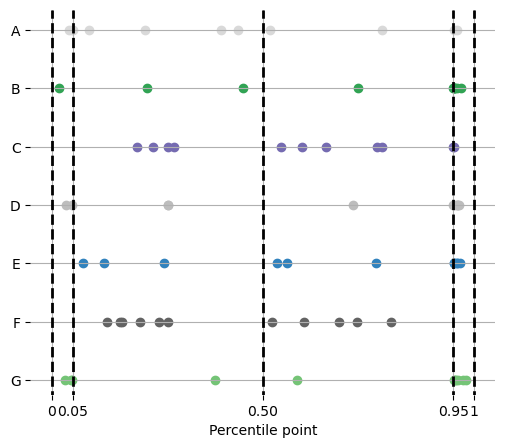

In [6]:
# Plot of realizations in the experts' distributions

def eval_ecdf(obs, x):
    interp_ecdf = interp1d(obs[0], obs[1])
    return interp_ecdf(x)

# p vector
p = [0, 0.05, 0.5, 0.95, 1]

# realizations
realizations = pd.DataFrame.from_dict(project.items.as_dict())

# bounds
bounds = project.assessments.get_bounds(overshoot=0.1)

# select the question for which we want to plot the different CDFs
itemnr = np.linspace(1, 12, 12)

fig, ax = plt.subplots(figsize=(6, 5))

# Get experts assessments for the item
for i in itemnr: #for each item
    i = int(i)

    #extract assessments for item i, each row an expert
    itemassessment = project.assessments.get_array(experts='actual')[:, :, i]

    # Get bounds for the item i
    lower, upper = bounds[0][i], bounds[1][i]

    for j in range(7): #for each expert
        vals = [lower, itemassessment[j][0], itemassessment[j][1], itemassessment[j][2], upper]
        ax.scatter(eval_ecdf(np.array([vals, p]), realizations['realization'][i]), 6-j, 
                   color = expert_colors[j])

ax.set_xlabel('Percentile point')
ax.set_yticks([0, 1, 2, 3, 4, 5, 6])
ax.set_yticklabels(['G', 'F', 'E', 'D', 'C', 'B', 'A'])
ax.set_xticks([0, 0.05, 0.50, 0.95, 1])
ax.set_xticklabels(['0', '0.05', '0.50', '0.95', '1'])
ax.plot([0, 0], [-0.35, 6.35], '--k', linewidth = 2)
ax.plot([0.05, 0.05], [-0.35, 6.35], '--k', linewidth = 2)
ax.plot([0.5, 0.5], [-0.35, 6.35], '--k', linewidth = 2)
ax.plot([0.95, 0.95], [-0.35, 6.35], '--k', linewidth = 2)
ax.plot([1, 1], [-0.35, 6.35], '--k', linewidth = 2)
ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.25,6.35)
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

### Compute scores per expert and decision makers

In [7]:
# Calculate decision maker with performance based weights
project.calculate_expert_robustness(
    weight_type='global',
    overshoot=0.1,  # this is the k factor that adjusts the range of the support
    max_exclude = 0 # this means no robustness analysis is performed  
)

project.experts.user_weights[0:7] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] # Equal weight DM

# Calculate decision maker with user defined weights
project.calculate_decision_maker(
    weight_type='user',
    overshoot=0.1,
    exp_id='DMeq',
    calpower=1.0,
    exp_name='Decision Maker equal weights',
    alpha=0.05,
    overwrite=True
)


We have not defined user weights: that column should remain as NaNs.

In [8]:
pd.DataFrame.from_dict(project.experts.as_dict())
# Calculate decision maker with global weights, using performance based
project.calculate_decision_maker(
    weight_type='global',
    overshoot=0.1,
    exp_id='DMgl_noopt',
    calpower=1.0, # Calibration power, relative weight of the calibration compared
                  # to the information score
    exp_name='Decision Maker global weights no opt',
    alpha=0,    # Significance level for the calibration score. Experts with a lower
                  # calibration score get zero weight. If None, the weights
                  # are returnes for all possible significance levels 
                  # (unique calibration scores)
    overwrite=True
)


In [9]:
# Calculate decision maker with global weights, using performance based
project.calculate_decision_maker(
    weight_type='global',
    overshoot=0.1,
    exp_id='DMgl',
    calpower=1.0, # Calibration power, relative weight of the calibration compared
                  # to the information score
    exp_name='Decision Maker global weights',
    alpha=0.05,    # Significance level for the calibration score. Experts with a lower
                  # calibration score get zero weight. If None, the weights
                  # are returnes for all possible significance levels 
                  # (unique calibration scores)
    overwrite=True
)
pd.DataFrame.from_dict(project.experts.as_dict())

,Name,Info. score total,Info. score real.,Calibration score,Answered seed items,Weight,User weight
A,A,1.893018,2.212611,3.599451e-02,12.0,0.000000,1.0
B,B,2.615340,3.286677,1.149098e-07,12.0,0.000000,1.0
C,C,1.455651,1.454842,2.982314e-01,12.0,0.433879,1.0
D,D,2.283855,3.118967,5.589438e-07,12.0,0.000000,1.0
E,E,1.690029,2.040376,1.596044e-03,12.0,0.000000,1.0
F,F,1.080189,0.889327,4.701352e-01,12.0,0.418104,1.0
G,G,1.832193,2.407726,1.419482e-06,12.0,0.000000,1.0
DMeq,Decision Maker equal weights,0.473789,0.567152,1.289207e-01,NaN,0.073118,NaN
DMgl_noopt,Decision Maker global weights no opt,0.756034,0.658902,4.701352e-01,NaN,0.309773,NaN
DMgl,Decision Maker global weights,0.845789,0.651589,4.701352e-01,NaN,0.306335,NaN


### Obtained CDF for different phreatic levels

(-2.0, 8.0)

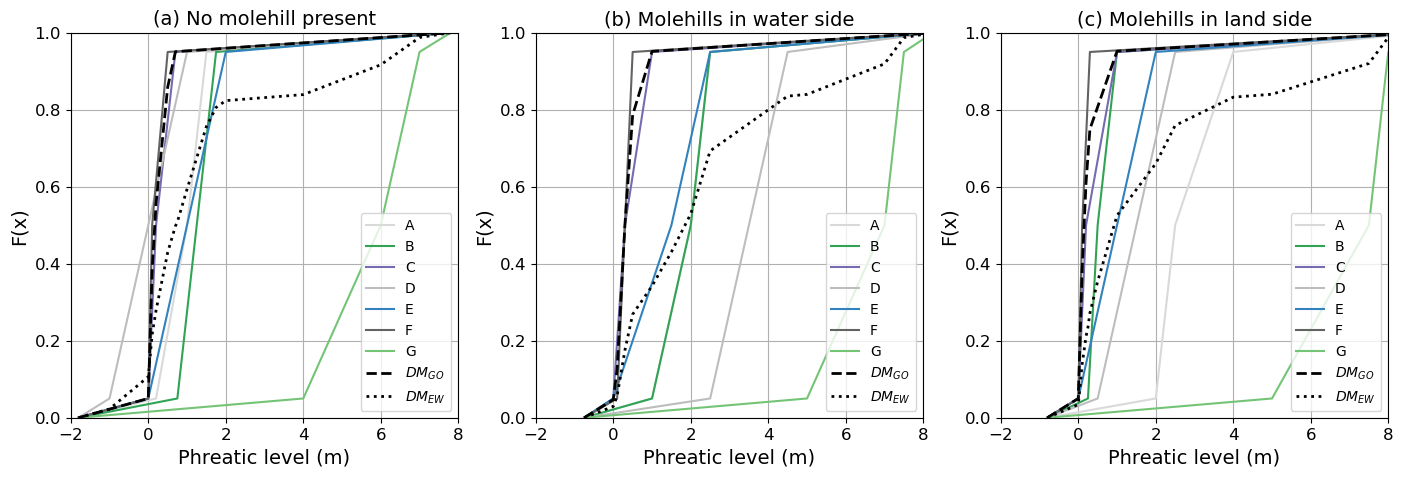

In [10]:
#select the question for which we want to plot the different CDFs
item = 'item17'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]

# Plot experts' cdfs
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

for i, assessment in enumerate(itemassessment):
    ax[0].plot(np.r_[lower, assessment, upper], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[0].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[0].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax[0].legend(loc = 'lower right')

ax[0].set_title('(a) No molehill present', fontsize=14)
ax[0].set_xlabel('Phreatic level (m)', fontsize=14)
ax[0].set_ylabel('F(x)', fontsize=14)
ax[0].grid()
ax[0].set_ylim(0,1)
ax[0].set_xlim(-2, 8)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].tick_params(axis='both', which='minor', labelsize=12)

#select the question for which we want to plot the different CDFs
item = 'item18'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]


for i, assessment in enumerate(itemassessment):
    ax[1].plot(np.r_[lower, assessment, upper], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[1].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[1].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax[1].legend(loc = 'lower right')

ax[1].set_title('(b) Molehills in water side', fontsize=14)
ax[1].set_xlabel('Phreatic level (m)', fontsize=14)
ax[1].set_ylabel('F(x)', fontsize=14)
ax[1].grid()
ax[1].set_ylim(0,1)
ax[1].set_xlim(-2, 8)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].tick_params(axis='both', which='minor', labelsize=12)

#select the question for which we want to plot the different CDFs
item = 'item19'
itemnr = project.items.ids.index(item)

# Get experts assessments for the item
itemassessment = project.assessments.get_array(experts='actual')[:, :, itemnr]
# Get bounds for the item
bounds = project.assessments.get_bounds(overshoot=0.1)
lower, upper = bounds[0][itemnr], bounds[1][itemnr]


for i, assessment in enumerate(itemassessment):
    ax[2].plot(np.r_[lower, assessment, upper], np.r_[0.0, project.assessments.quantiles, 1.0], color = expert_colors[i],
            label='{}'.format(project.experts.ids[i]))
    
# Plot DM's cdf
ax[2].plot(*project.assessments.full_cdf['DMgl'][itemnr].T, label='${DM_{GO}}$', ms=4, color='k', ls='--', lw=2)
ax[2].plot(*project.assessments.full_cdf['DMeq'][itemnr].T, label='${DM_{EW}}$', ms=4, color='k', ls=':', lw=2)

ax[2].legend(loc = 'lower right')

ax[2].set_title('(c) Molehills in land side', fontsize=14)
ax[2].set_xlabel('Phreatic level (m)', fontsize=14)
ax[2].set_ylabel('F(x)', fontsize=14)
ax[2].grid()
ax[2].set_ylim(0,1)
ax[2].tick_params(axis='both', which='major', labelsize=12)
ax[2].tick_params(axis='both', which='minor', labelsize=12)
ax[2].set_xlim(-2, 8)

### Infinite slope

In [32]:
def eval_cdf(obs, x):
    interp_ecdf = interp1d(obs[:,1], obs[:,0], kind='linear')
    return interp_ecdf(x)

simulations = 500

# samples no moles
item = 'item17'
itemnr = project.items.ids.index(item)
unif_unity_phrea = stats.uniform.rvs(0, 1, size = simulations, random_state=0)
unif_samples_phrea = eval_cdf(project.assessments.full_cdf['DMgl'][itemnr], unif_unity_phrea) 

# samples moles water
item = 'item18'
itemnr = project.items.ids.index(item)
unif_samples_water = eval_cdf(project.assessments.full_cdf['DMgl'][itemnr], unif_unity_phrea) 

# samples moles land
item = 'item19'
itemnr = project.items.ids.index(item)
unif_samples_land = eval_cdf(project.assessments.full_cdf['DMgl'][itemnr], unif_unity_phrea) 

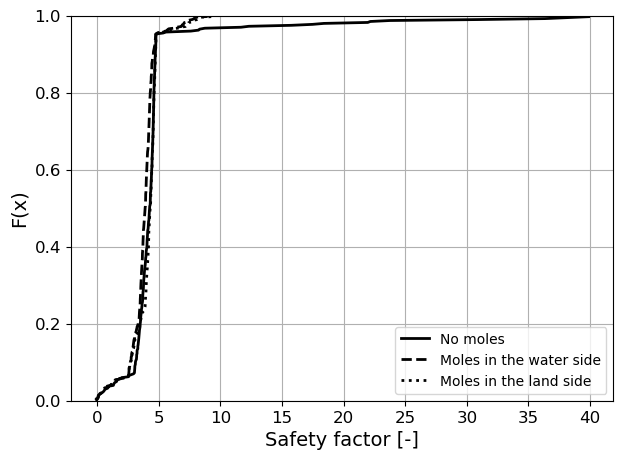

In [35]:
# Infinite slope 

def safety_factor(cohesion, friction_angle, unit_weight_sat, unit_weight_dry, phreatic_level, slope_angle, d, unit_weight_water):
    dw = phreatic_level/(np.cos(slope_angle*np.pi/180)**2)
    upper = cohesion + np.cos(slope_angle*np.pi/180)**2 * np.tan(friction_angle*np.pi/180) * (unit_weight_sat*dw + unit_weight_dry*(d-dw) - unit_weight_water*dw)
    lower = np.sin(slope_angle*np.pi/180)*np.cos(slope_angle*np.pi/180)*(unit_weight_sat*dw + unit_weight_dry*(d-dw))
    return upper/lower


c = 10 #kPa
phi = 20 #degrees
lambda_sat = 20 #kN/m3
lambda_dry = 15 #kN/m3
angle_slope = math.atan(1/3)*180/np.pi

safety_factors_no_moles = [safety_factor(c, phi, lambda_sat, lambda_dry, p, angle_slope, 0.6, 9.81) for p in unif_samples_phrea]
safety_factors_water = [safety_factor(c, phi, lambda_sat, lambda_dry, p, angle_slope, 0.6, 9.81) for p in unif_samples_water]
safety_factors_land = [safety_factor(c, phi, lambda_sat, lambda_dry, p, angle_slope, 0.6, 9.81) for p in unif_samples_land]


def ecdf(var):
    x = np.sort(var)
    n = x.size
    y = np.arange(1, n+1) / (n+1)
    return [y, x]

# Plot experts' cdfs
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(ecdf(safety_factors_no_moles[100:])[1], ecdf(safety_factors_no_moles[100:])[0], label='No moles', ms=4, color='k', lw=2)
ax.plot(ecdf(safety_factors_water)[1], ecdf(safety_factors_water)[0], label='Moles in the water side', ms=4, color='k', ls='--', lw=2)
ax.plot(ecdf(safety_factors_land)[1], ecdf(safety_factors_land)[0], label='Moles in the land side', ms=4, color='k', ls=':', lw=2)


ax.legend(loc = 'lower right')

ax.set_xlabel('Safety factor [-]', fontsize=14)
ax.set_ylabel('F(x)', fontsize=14)
ax.grid()
ax.set_ylim(0,1)
# ax.set_xlim(-2, 8)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)



In [29]:
safety_factors_no_moles.index(min(safety_factors_no_moles))

99